In [1]:
# libraries used
import numpy as np
import pandas as pd

# from sklearn.model_selection import train_test_split  ??
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# PLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# importing the merged dataset
data = pd.read_csv('ensembleMean_merged.csv')

First of all, we split the data set into training and testing in order to get a higher precision of metrics. 

The training part includes the electricity data before year 2018 while the testing set includes the electricity data after 2018. 

In [3]:
# splitting data set into training set and testing set (OUTER)

train = data[data['time']<'2018-01-01 00:00:00'] # trainig set are data from dates before 2018
test = data[data['time']>='2018-01-01 00:00:00'] # testing set are data from dates after 2018

In [4]:
# splitting the sets into variables and response
y_train = train['response'].values
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]].values

y_test = test['response'].values
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]].values

In [5]:
# Splitting indeces to create a custom cv 

train_indices = list(range(0,5844))             # dates before 2017 to train
test_indices = list(range(5844, len(train)))    # dates from 2017 to 2018 to validate (INNER)
custom_cv = [(train_indices, test_indices)]

Creating functions in order to facilitate the procedures afterwards

In [6]:
# 1. Random forest
def optimize_rf(x_train, y_train, params_rf):
    rf=RandomForestRegressor(random_state = 10)
    rf_search = RandomizedSearchCV(rf, params_rf, cv=custom_cv, n_iter = 30)
    rf_search.fit(x_train, y_train)
    return rf_search.best_estimator_

In [7]:
# 2. Gradient boosting
def optimize_gb(x_train, y_train, params_gb):
    gb=GradientBoostingRegressor(random_state = 10)
    gb_search = RandomizedSearchCV(gb, params_gb, cv=custom_cv, n_iter = 30)
    gb_search.fit(x_train, y_train)
    return gb_search.best_estimator_

In [8]:
# 3. SVM
def optimize_svm(x_train, y_train, params_svm):   
    svm = SVR()
    svm_search = RandomizedSearchCV(svm, params_svm, cv=custom_cv, n_iter = 30)
    svm_search.fit(x_train, y_train)
    return svm_search.best_estimator_

### Defining Metric Matrix

With the intention of visualization of the different results of metrics per model, we create a matrix that displays all the results of each model per each data set that we modify. 

Also, it is necessary to create a function that automatically does the imputation in the matrix for us. 

The function made requires 5 arguments: the true reponse (y element) for training set and testing set; the prediction of the response that the different models have made and the name of the model. 

In [9]:
# creating a metrics matrix in order to visualize the different results
df_metricas=pd.DataFrame(columns=['train_R2', 'test_R2', 'train_MAXerror', 'test_MAXerror',
                                 'train_mae', 'test_mae', 'train_mse', 'test_mse', 
                                  'train_rmse', 'test_rmse'], 
                         index=['RF_1','GB_1','SVM_1',  # 1 means 10 components after dimension reduction
                                'RF_2','GB_2','SVM_2',  # 2 means 15 components after dimension reduction
                                'RF_3','GB_3','SVM_3']) # 3 means 20 components after dimension reduction

In [10]:
# Metrics for evaluating
def metrics(y_train, pred_train, y_test, pred_test, model):
    # Varianza explicada
    ve_train = explained_variance_score(y_train, pred_train)
    ve_test = explained_variance_score(y_test, pred_test)
    print('explained variance of training set:',(ve_train))
    print('explained variance of testing set:',(ve_test))
    df_metricas.loc[model, 'train_R2']=ve_train
    df_metricas.loc[model, 'test_R2']=ve_test
    # Maximum error
    me_train = max_error(pred_train, y_train)
    me_test = max_error(pred_test, y_test)
    print('maximum error of training set:',(me_train))
    print('maximum error of testing set:',(me_test))
    df_metricas.loc[model, 'train_MAXerror']=me_train
    df_metricas.loc[model, 'test_MAXerror']=me_test
    # mean absolute error: datos mal predichos, no al cuadrado, menor peso
    mae_train = mean_absolute_error(pred_train, y_train)
    mae_test = mean_absolute_error(pred_test, y_test)
    print('mae of training set:',(mae_train))
    print('mae of testing set:',(mae_test))
    df_metricas.loc[model, 'train_mae']=mae_train
    df_metricas.loc[model, 'test_mae']=mae_test
    # mean squared error: al cuadrado 
    # raiz de mse
    mse_train = mean_squared_error(pred_train, y_train)
    mse_test = mean_squared_error(pred_test, y_test)
    print('mse of training set:',(mse_train))
    print('mse of testing set:',(mse_test))
    df_metricas.loc[model, 'train_mse']=mse_train
    df_metricas.loc[model, 'test_mse']=mse_test
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    print('rmse of training set:',(rmse_train))
    print('rmse of testing set:',(rmse_test))
    df_metricas.loc[model, 'train_rmse']=rmse_train
    df_metricas.loc[model, 'test_rmse']=rmse_test

### ALL VARIABLES

In [11]:
def optimise_pls_cv(X, y, n_comp):
    # Defining PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross validation prediction
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate metrics
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    mae = mean_absolute_error(y, y_cv)

    return (y_cv, r2, mse, rpd, mae)

In [12]:
# test with 30 components
r2s = []
mses = []
rpds = []
maes = []

xticks = np.arange(1, 30)
for n_comp in xticks:
    y_cv, r2, mse, rpd, mae = optimise_pls_cv(x_train, y_train, n_comp)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)
    maes.append(mae)

In [13]:
# Plot the metrics
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

We can observe from the following plots that, with 21 components it gets to the optimal values for the metrics: highest R2 and lowest MSE. 

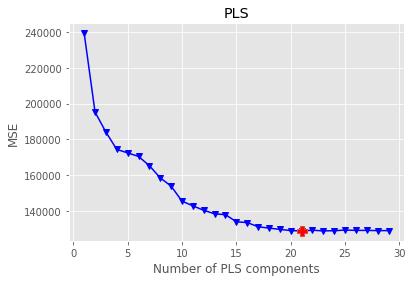

In [14]:
plot_metrics(mses, 'MSE', 'min')

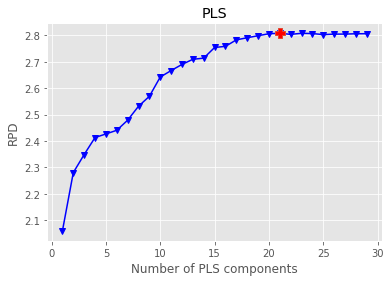

In [15]:
plot_metrics(rpds, 'RPD', 'max')

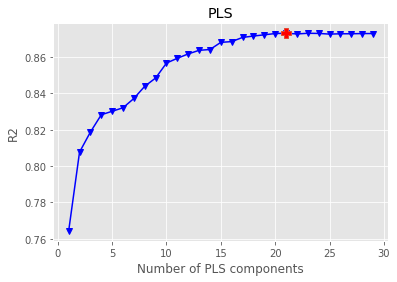

In [16]:
plot_metrics(r2s, 'R2', 'max')

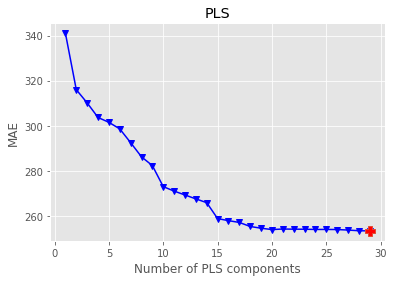

In [17]:
plot_metrics(maes, 'MAE', 'min')

But in order to aviod overfitting with the training set, we will try to use 3 values of components to see if smaller values will work better. 

In [18]:
pls1 = PLSRegression(n_components=10).fit(x_train, y_train)
x_train_1 = pls1.transform(x_train)
x_test_1 = pls1.transform(x_test)

In [19]:
pls2 = PLSRegression(n_components=15).fit(x_train, y_train)
x_train_2 = pls2.transform(x_train)
x_test_2 = pls2.transform(x_test)

In [20]:
pls3 = PLSRegression(n_components=20).fit(x_train, y_train)
x_train_3 = pls3.transform(x_train)
x_test_3 = pls3.transform(x_test)

#### 1. Random forest

In [21]:
params_rf1 = {'max_depth': sp_randint(2, 5), 
             'min_samples_leaf': sp_randint(10, 25),
             'n_estimators': sp_randint(150, 280)}

rf1 = optimize_rf(x_train_1, y_train, params_rf1)
rf1

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=23,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=260, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [22]:
rf1_pred_train = rf1.predict(x_train_1)
rf1_pred_test = rf1.predict(x_test_1)

metrics(y_train, rf1_pred_train, y_test, rf1_pred_test, 'RF_1')

explained variance of training set: 0.8804440335058753
explained variance of testing set: 0.8425648007507948
maximum error of training set: 2021.916597090995
maximum error of testing set: 1964.9858883609654
mae of training set: 252.60132410401764
mae of testing set: 257.0780499921427
mse of training set: 121415.6475997765
mse of testing set: 133623.35296166368
rmse of training set: 348.44748183876504
rmse of testing set: 365.5452816843129


In [23]:
params_rf2 = {'max_depth': sp_randint(2, 5), 
             'min_samples_leaf': sp_randint(10, 25),
             'n_estimators': sp_randint(150, 280)}

rf2 = optimize_rf(x_train_2, y_train, params_rf2)
rf2

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=24,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=180, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [24]:
rf2_pred_train = rf2.predict(x_train_2)
rf2_pred_test = rf2.predict(x_test_2)

metrics(y_train, rf2_pred_train, y_test, rf2_pred_test, 'RF_2')

explained variance of training set: 0.8811043346510912
explained variance of testing set: 0.8425122090296971
maximum error of training set: 2005.268795331529
maximum error of testing set: 1968.721513645287
mae of training set: 251.92039021694728
mae of testing set: 257.00712781160803
mse of training set: 120745.06763950066
mse of testing set: 133627.31183240475
rmse of training set: 347.48390990015736
rmse of testing set: 365.55069666518864


In [25]:
params_rf3 = {'max_depth': sp_randint(2, 5), 
             'min_samples_leaf': sp_randint(10, 25),
             'n_estimators': sp_randint(150, 280)}

rf3 = optimize_rf(x_train_3, y_train, params_rf3)
rf3

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=24,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=263, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [26]:
rf3_pred_train = rf3.predict(x_train_3)
rf3_pred_test = rf3.predict(x_test_3)

metrics(y_train, rf3_pred_train, y_test, rf3_pred_test, 'RF_3')

explained variance of training set: 0.8819012792633988
explained variance of testing set: 0.8404475881868968
maximum error of training set: 2022.6254365191794
maximum error of testing set: 1965.080909169981
mae of training set: 251.14027099184932
mae of testing set: 257.7807294581849
mse of training set: 119935.75328892595
mse of testing set: 135288.82169843436
rmse of training set: 346.31741695867095
rmse of testing set: 367.81628797326846


#### 2 Gradient Boosting

In [27]:
params_gb1 = {'learning_rate': loguniform(0.0001, 0.3),
             'max_depth': sp_randint(2, 5), 
             'min_samples_leaf': sp_randint(10, 25),
             'n_estimators': sp_randint(180, 280)}

gb1 = optimize_gb(x_train_1, y_train, params_gb1)
gb1

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.031711858436887556,
                          loss='ls', max_depth=4, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=23,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=254, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [28]:
gb1_pred_train = gb1.predict(x_train_1)
gb1_pred_test = gb1.predict(x_test_1)

metrics(y_train, gb1_pred_train, y_test, gb1_pred_test, 'GB_1')

explained variance of training set: 0.9432264654824059
explained variance of testing set: 0.9006478529374544
maximum error of training set: 1354.996405725516
maximum error of testing set: 1560.2560514553825
mae of training set: 169.39885638512158
mae of testing set: 198.0114881654344
mse of training set: 57656.63699953231
mse of testing set: 83922.80137725736
rmse of training set: 240.11796475801702
rmse of testing set: 289.6943240335533


In [29]:
params_gb2 = {'learning_rate': loguniform(0.0001, 0.3),
             'max_depth': sp_randint(2, 5), 
             'min_samples_leaf': sp_randint(10, 25),
             'n_estimators': sp_randint(180, 280)}

gb2 = optimize_gb(x_train_2, y_train, params_gb2)
gb2

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.0793386643732572,
                          loss='ls', max_depth=4, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=24,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=273, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [30]:
gb2_pred_train = gb2.predict(x_train_2)
gb2_pred_test = gb2.predict(x_test_2)

metrics(y_train, gb2_pred_train, y_test, gb2_pred_test, 'GB_2')

explained variance of training set: 0.9579665118435983
explained variance of testing set: 0.9036384089363498
maximum error of training set: 1184.9369753629765
maximum error of testing set: 1622.7921092800866
mae of training set: 146.15563839860977
mae of testing set: 193.01800456161916
mse of training set: 42687.31177388201
mse of testing set: 81400.41446590342
rmse of training set: 206.60907960174936
rmse of testing set: 285.3075787039374


In [31]:
params_gb3 = {'learning_rate': loguniform(0.0001, 0.3),
              'max_depth': sp_randint(2, 5), 
              'min_samples_leaf': sp_randint(10, 25),
              'n_estimators': sp_randint(180, 280)}

gb3 = optimize_gb(x_train_3, y_train, params_gb3)
gb3

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.0757677153761669,
                          loss='ls', max_depth=4, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=21,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=210, n_iter_no_change=None,
                          presort='deprecated', random_state=10, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [32]:
gb3_pred_train = gb3.predict(x_train_3)
gb3_pred_test = gb3.predict(x_test_3)

metrics(y_train, gb3_pred_train, y_test, gb3_pred_test, 'GB_3') 

explained variance of training set: 0.9568803756884567
explained variance of testing set: 0.9046966579281026
maximum error of training set: 1330.7312462588636
maximum error of testing set: 1530.3936181797021
mae of training set: 147.87581820635612
mae of testing set: 191.9709188700382
mse of training set: 43790.342588524385
mse of testing set: 80505.49304098873
rmse of training set: 209.26142164413483
rmse of testing set: 283.7348992298775


#### 1.3 Support Vector Machine

In [33]:
params_svm1 = {'C': loguniform(10e-4, 10e+4),
               'gamma': loguniform(10e-4, 10e+1),
               'kernel': ['rbf']}

svm1 = optimize_svm(x_train_1, y_train, params_svm1)
svm1

SVR(C=63031.439053831324, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.0042494652986947105, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
svm1_pred_train = svm1.predict(x_train_1)
svm1_pred_test = svm1.predict(x_test_1)

metrics(y_train, svm1_pred_train, y_test, svm1_pred_test, 'SVM_1')

explained variance of training set: 0.9450985349316079
explained variance of testing set: 0.9022297123803548
maximum error of training set: 1553.2079146180986
maximum error of testing set: 1707.416115723103
mae of training set: 154.303133003033
mae of testing set: 187.83054775298842
mse of training set: 55906.004023769725
mse of testing set: 82794.38378227595
rmse of training set: 236.4445051672162
rmse of testing set: 287.74013238037537


In [35]:
params_svm2 = {'C': loguniform(10e-4, 10e+4),
               'gamma': loguniform(10e-4, 10e+1),
               'kernel': ['rbf']}

svm2 = optimize_svm(x_train_2, y_train, params_svm2)
svm2

SVR(C=29036.847160558627, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.0010093562528404197, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [36]:
svm2_pred_train = svm2.predict(x_train_2)
svm2_pred_test = svm2.predict(x_test_2)

metrics(y_train, svm2_pred_train, y_test, svm2_pred_test, 'SVM_2')

explained variance of training set: 0.9365056986455171
explained variance of testing set: 0.9087103527632782
maximum error of training set: 1938.78730803917
maximum error of testing set: 1542.106699776445
mae of training set: 171.99466713860667
mae of testing set: 184.67369517218341
mse of training set: 64632.27363800431
mse of testing set: 77447.720639183
rmse of training set: 254.22878208024423
rmse of testing set: 278.29430579726744


In [37]:
params_svm3 = {'C': loguniform(10e-4, 10e+4),
               'gamma': loguniform(10e-4, 10e+1),
               'kernel': ['rbf']}

svm3 = optimize_svm(x_train_3, y_train, params_svm3)
svm3

SVR(C=3712.0447770228097, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.002452140569206562, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
svm3_pred_train = svm3.predict(x_train_3)
svm3_pred_test = svm3.predict(x_test_3)

metrics(y_train, svm3_pred_train, y_test, svm3_pred_test, 'SVM_3') # best metric up to now

explained variance of training set: 0.9395378217583087
explained variance of testing set: 0.9119841803681928
maximum error of training set: 1824.3701519967394
maximum error of testing set: 1565.8070435430916
mae of training set: 166.38381204240278
mae of testing set: 179.85094728441436
mse of training set: 61525.47448044364
mse of testing set: 74791.52359437026
rmse of training set: 248.043291544931
rmse of testing set: 273.48038978027336


In [39]:
df_metricas # SVM_3

,train_R2,test_R2,train_MAXerror,test_MAXerror,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse
RF_1,0.880444,0.842565,2021.92,1964.99,252.601,257.078,121416,133623,348.447,365.545
GB_1,0.943226,0.900648,1355,1560.26,169.399,198.011,57656.6,83922.8,240.118,289.694
SVM_1,0.945099,0.90223,1553.21,1707.42,154.303,187.831,55906,82794.4,236.445,287.74
RF_2,0.881104,0.842512,2005.27,1968.72,251.92,257.007,120745,133627,347.484,365.551
GB_2,0.957967,0.903638,1184.94,1622.79,146.156,193.018,42687.3,81400.4,206.609,285.308
SVM_2,0.936506,0.90871,1938.79,1542.11,171.995,184.674,64632.3,77447.7,254.229,278.294
RF_3,0.881901,0.840448,2022.63,1965.08,251.14,257.781,119936,135289,346.317,367.816
GB_3,0.95688,0.904697,1330.73,1530.39,147.876,191.971,43790.3,80505.5,209.261,283.735
SVM_3,0.939538,0.911984,1824.37,1565.81,166.384,179.851,61525.5,74791.5,248.043,273.48
